# Init

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
#import btreceptor as bt 
%matplotlib inline
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
import plotly
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 500
   }
mpl.rcParams.update(params)
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")
sns.set_palette('colorblind')

savefig_args = {"dpi": 500, "bbox_inches": "tight", "pad_inches": 0.05}
mpl.rc('savefig', dpi=500)
output_dir = "../../figures/tcr_clonality/"
if not os.path.exists(output_dir):
            os.makedirs(output_dir)
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

### BtReceptor Edited for T cell data 

from __future__ import division
import pandas as pd
import numpy as np
import Levenshtein
from scipy.spatial.distance import squareform
from scipy.sparse.csgraph import connected_components
from itertools import combinations


def donor_colors():
    donors = ['TSP1','TSP2','TSP3','TSP4','TSP5','TSP6','TSP7','TSP8','TSP9','TSP10','TSP11','TSP12','TSP13','TSP14','TSP15']
    
    import matplotlib.colors as pltcolors
    
    cmap = plt.cm.get_cmap("YlGnBu")
        
    donor_color_dict = {}
    j=1/len(donors)
    for d in donors:
        donor_color_dict[d] = pltcolors.to_hex(cmap(j))
        j+=1/len(donors)
        
    return donor_color_dict


def donor_colors():
    donor_color_dict = {'TSP6': '#034001', 'TSP7': '#8FBC8F', 'TSP4': '#c5ba30', 'TSP5': '#DC143C', 
                    'TSP10': '#FFD700', 'TSP8': '#8839ff', 'TSP3': '#c34a17', 'TSP11': '#00edff', 
                    'TSP12': '#f507a0', 'TSP9': '#9CADCA', 'TSP14': '#27BFD2', 'TSP15': '#bc7c00', 
                    'TSP1': '#4169E1', 'TSP2': '#636c8c', 'TSP13': '#ADD8E6'}
    return donor_color_dict

from numpy.random import seed


def df_generate_node_dict(frame, singletons=False):
    """ Generates a node property dictionary for downstream graph-tool plotting
        Args:
            frame (pd.Dataframe) with the following columns:
                - clone_id (mandatory)
                - node_color (optional)
                - node_shape (optional)
                - node_size (optional)
                - node_stroke (optional)
            singletons (bool): whether to include cells that do not form
                multi-member clonal families
        Returns:
            dict: nested as follows: {node_id: {'property1': 'value1', ...}}
    """
    frame = frame.copy()

    # use some defaults if property columns are missing
    req_key_defaults = {'node_color': 'blue',
                        'node_shape': 'circle',
                        'node_size': .1,
                        'node_stroke': 0.5}
    for key, default in req_key_defaults.items():
        if key not in frame.columns:
            frame[key] = default  # add column to dataframe

    node_props = {}
    node_id = 0
    for lin, g in frame.groupby('clone_id'):
        if g.shape[0] > 1 or singletons:
            if g.shape[0] > 1:
                # add a germline to root all cells in a clone_id
                gid = node_id
                node_props[gid] = {'color': 'k',
                                   'ancestor': None,
                                   'size': frame['node_size'].min(),
                                   'shape': 'circle',
                                   'stroke': 0}
                node_id += 1
            else:
                # no germline root for a singleton
                gid = None

            # add cell(s) with properties
            for _, row in g.iterrows():
                node_props[node_id] = {'ancestor': gid,
                                       'color': row['node_color'],
                                       'shape': row['node_shape'],
                                       'size': row['node_size'],
                                       'stroke': row['node_stroke']
                                       }
                node_id += 1

    return node_props


def draw_gviz(node_dict, size_multiple=50, random_seed=42, **kwargs):
    """ Draw clonal network using graph-tool
    More information: graphtool edge / vertex parameters and examples:
        https://graph-tool.skewed.de/static/doc/draw.html#graph_tool.draw.graph_draw
        http://ryancompton.net/2014/10/05/graph-tools-visualization-is-pretty-good/
    Args:
        node_dict (dict): nested dictionary of node properties
            Generate this using df_generate_node_dict()
        size_multiple (int): scaling factor for node size (for convenience)
        **kwargs: keyword arguments passed to gt.graph-draw()
            e.g. output='file.pdf', layout='neato', output_size=(300,300)
    """
    import graph_tool.all as gt

    g = gt.Graph()
    vsizes = g.new_vertex_property("int")
    vcolors = g.new_vertex_property('string')
    vshapes = g.new_vertex_property('string')
    vpenwidth = g.new_vertex_property("float")  # stroke

    for node_id, node_props in node_dict.items():
        g.add_vertex()

        vshapes[g.vertex(node_id)] = node_props['shape']
        vcolors[g.vertex(node_id)] = node_props['color']
        vsizes[g.vertex(node_id)] = node_props['size']*size_multiple
        vpenwidth[g.vertex(node_id)] = node_props['stroke']

        # add edge to ancestor
        if node_props['ancestor'] is not None:
            g.add_edge(node_props['ancestor'], node_id)

    # seeds enable graph reproduction
    seed(random_seed)
    gt.seed_rng(random_seed)

    gt.graph_draw(g,
                  vertex_size=vsizes,
                  vertex_fill_color=vcolors,
                  vertex_shape=vshapes,
                  vertex_pen_width=vpenwidth,
                  vertex_color='k',  # stroke color
                  bg_color=[1, 1, 1, 1],  # white
                  edge_end_marker='none',
                  **kwargs)
    
    
# visualize the color dictionaries
def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    by_hsv = [(v, k) for k, v in colors.items()]
    
    if sort_colors is True:
        by_hsv = sorted(by_hsv)
    names = [name for hsv, name in by_hsv]

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        swatch_end_x = cell_width * col + swatch_width
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y, swatch_start_x, swatch_end_x,
                  color=colors[name], linewidth=18)

    return fig

def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        print(idx, colorNum)
        colorList = colorList + [colorPalette[idx]]*colorNum
        print(colorList)
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [10]:
df = pd.read_table('../../data/merged_airr_scirpy.tsv')
df = df[df.receptor_type == 'TCR']

In [12]:
## Permutation Test on Clones of size larger than 3

In [13]:
# there must be a more laconic way to do this
selector = df.clone_id.value_counts() > 3
clone_ids = selector[selector == True].index
df = df[df.clone_id.isin(clone_ids)]

In [21]:
# number of singleton tissue clones (summary stat)
df.groupby('clone_id').tissue.nunique().value_counts()
df.groupby('clone_id').tissue.nunique().value_counts().iloc[0]

22

In [45]:
def permute_labels(_df, group, label):
    """ permutes the label within groups"""
    # create copy
    _df = df.copy(deep=True)
    # shuffle labels
    list_of_dfs = []
    for group, frame in _df.groupby(group):
        frame.loc[:,label] = np.random.permutation(frame.loc[:,label].values)
        list_of_dfs.append(frame)
        shuffled_df = pd.concat(list_of_dfs)    
        number_of_singletons = pd.DataFrame(shuffled_df.groupby(label).tissue.nunique().value_counts()).loc[1,:].values[0]
        
    return shuffled_df

In [58]:
permutations = 10000
summary_df_list = []
for i in range(permutations):
    permuted_df = permute_labels(df, "donor", "clone_id")
    permuted_df.loc[:,'permutation'] = i
    summary_df_list.append(permuted_df)

In [59]:
summary_df = pd.concat(summary_df_list)

In [60]:
summary_df.groupby(['permutation', 'clone_id']).tissue.nunique().mean()

3.056276271186441

In [61]:
df.groupby('clone_id').tissue.nunique().mean()

2.389830508474576

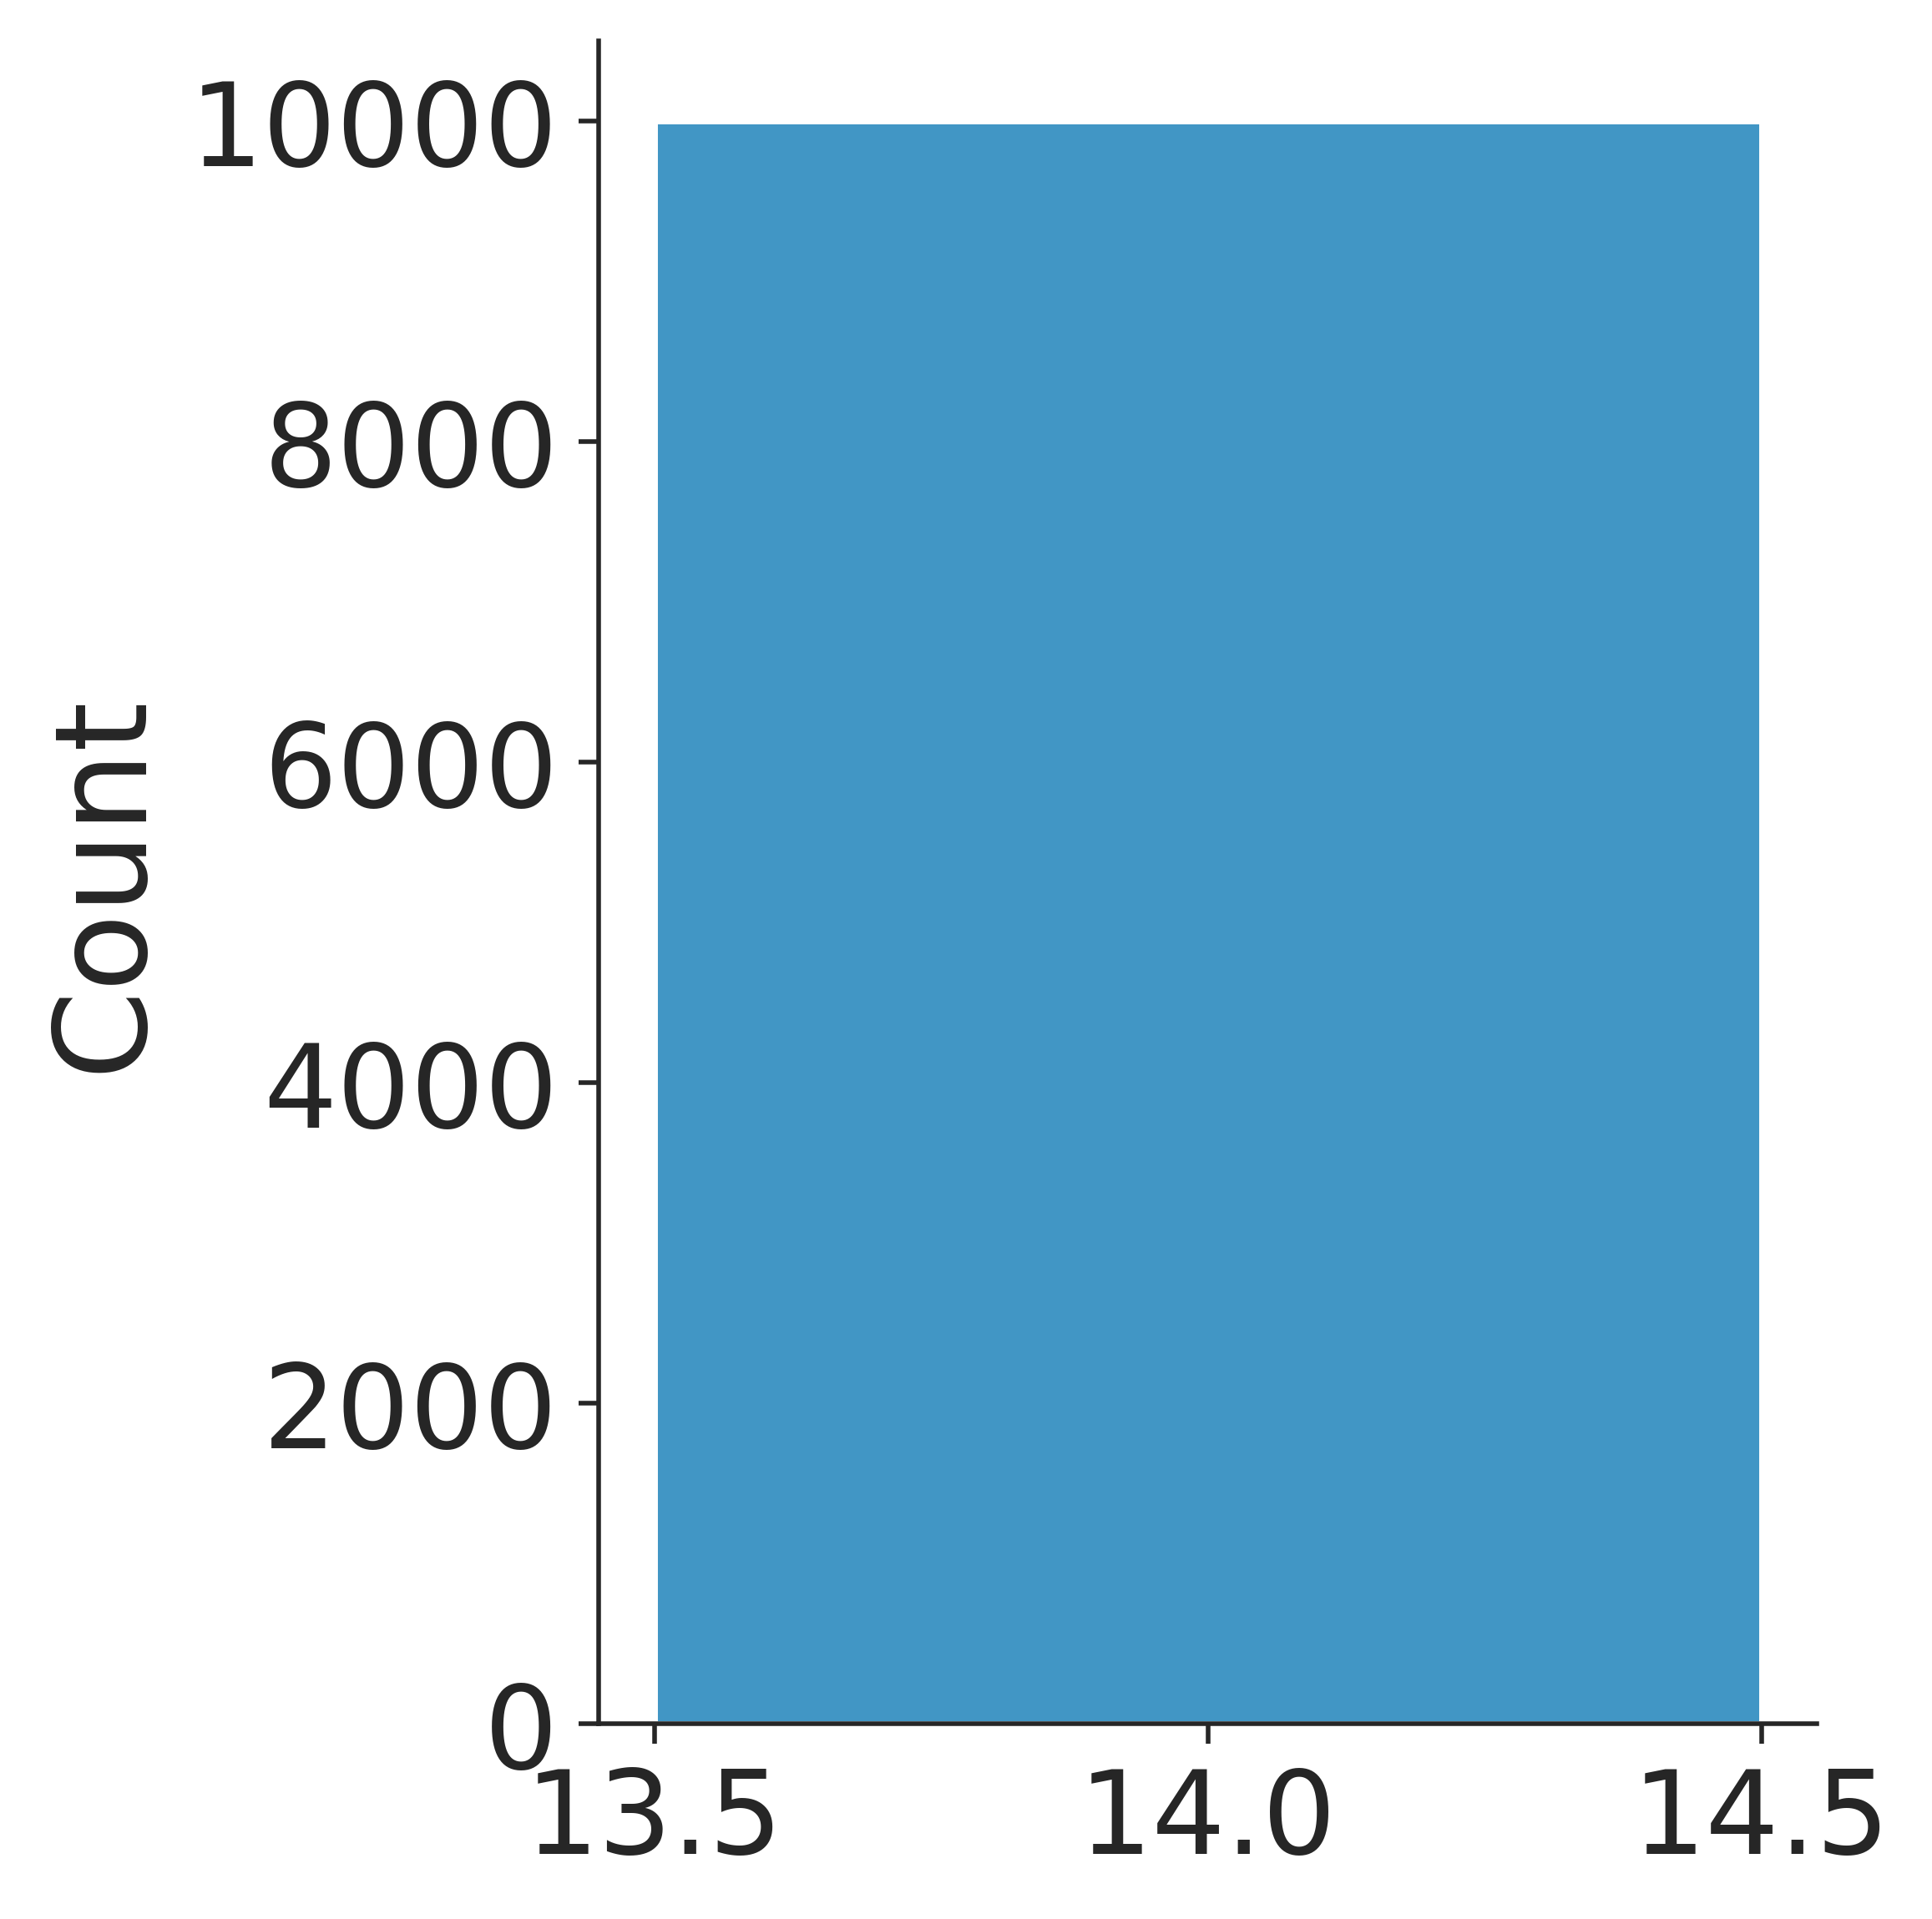

In [17]:
sns.displot(summary_stat)

In [122]:
pd.Series(summary_stat).quantile(0.999)

17.0

In [ ]:
ax = ir.pl.group_abundance(adata, groupby='receptor_subtype', target_col='tissue')

ax = ir.pl.group_abundance(adata, groupby='receptor_subtype', target_col='donor')


ax = ir.pl.group_abundance(adata, groupby='clone_id', target_col='cell_ontology_class', max_cols=10)

ax = ir.pl.vdj_usage(adata, full_combination=False, max_segments=None, max_ribbons=30)

ir.pl.vdj_usage(
    adata[adata.obs["clone_id"].isin(["546", "556", '626']), :],
    max_ribbons=None,
    max_segments=100,
)